In [1]:
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt

input_sdf = "mini_test.sdf"
input_sdf = "rot_MBZ_MBZ.sdf"

print("Count mols ...")
num_frag = 0
fragi_atom_num = 0
fragj_atom_num = 0
with Chem.SDMolSupplier(input_sdf, removeHs=False) as sdf:
    for m in sdf:
        num_frag += 1
    else:
        # last mol
        fragi_name, fragj_name = m.GetProp("FRAG_NAME").split()
        _, fragi, _, fragj = m.GetProp("FRAG_ATOM_NUM").split()
        fragi_atom_num, fragj_atom_num = int(fragi), int(fragj)
print(f"Total {num_frag} {fragi_name}-{fragj_name} pairs, num of atoms: {fragi_atom_num} + {fragj_atom_num}")


Count mols ...
Total 157128 MBZ-MBZ pairs, num of atoms: 15 + 15


In [2]:
print(f"Extract probe fragment coords from {num_frag} pair ...")
coords = np.zeros((num_frag, fragj_atom_num, 3))
with Chem.SDMolSupplier(input_sdf, removeHs=False) as sdf:
    for k, m in enumerate(sdf):
        xyz = m.GetConformer().GetPositions()
        coords[k] = xyz[:fragi_atom_num,:]


Extract probe fragment coords from 157128 pair ...


In [4]:
# def rmsd(ci, cj):
#     return np.sqrt(np.mean(np.sum((ci - cj)**2, axis=1)))

# def euclidean_dist(ci, cj):
#     return np.sqrt(np.sum((ci - cj)**2))

# rmsds = []
# dists = []
# for i in range(num_frag):
#     for j in range(i):
#         rmsds.append(rmsd(coords[i], coords[j]))
#         dists.append(euclidean_dist(coords[i], coords[j]))

# import matplotlib.pyplot as plt

# # euclidean_dist = sqrt(num_atom) * rmsd
# plt.scatter(rmsds, dists)

In [4]:
import umap
fit = umap.UMAP()
X = coords.reshape(num_frag, fragj_atom_num*3)
u = fit.fit_transform(X)

Text(0.5, 1.0, 'UMAP embedding of 157128 MBZ-MBZ pairs')

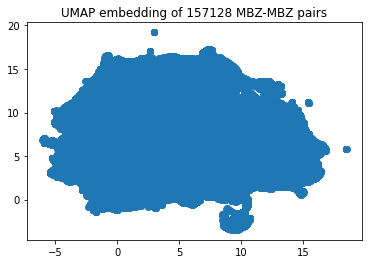

In [5]:
plt.scatter(u[:,0], u[:,1])
plt.title(f'UMAP embedding of {num_frag} {fragi_name}-{fragj_name} pairs')

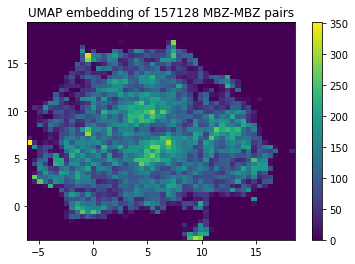

In [6]:
plt.hist2d(u[:,0], u[:,1], (50, 50))
plt.title(f'UMAP embedding of {num_frag} {fragi_name}-{fragj_name} pairs')
plt.colorbar()

In [7]:
# https://umap-learn.readthedocs.io/en/latest/densmap_demo.html
import umap
X = coords.reshape(num_frag, fragj_atom_num*3)
dens_mapper = umap.UMAP(densmap=True, random_state=42).fit(X)

<AxesSubplot:>

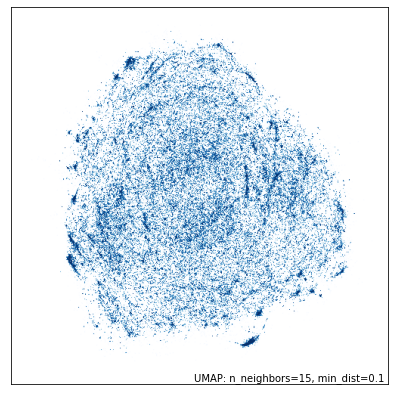

In [11]:
# conda install pandas matplotlib datashader bokeh holoviews scikit-image colorcet -c conda-forge -y
import umap.plot
umap.plot.points(dens_mapper, width=500, height=500)

In [15]:
from sklearn.cluster import OPTICS
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X[:10000])

OPTICS(min_cluster_size=0.05, min_samples=50)

In [16]:
# Run the fit
clust.fit(X[:20000])

OPTICS(min_cluster_size=0.05, min_samples=50)

In [17]:
(2*60 + 5)/38

3.289473684210526

In [19]:
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05, max_eps=15)
clust.fit(X[:20000])

OPTICS(max_eps=15, min_cluster_size=0.05, min_samples=50)

In [21]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=15, min_samples=50).fit(X[:20000])

In [ ]:
from sklearn.cluster import DBSCAN
# clustering = DBSCAN(eps=15, min_samples=50).fit(X) # two much memory, try NearestNeighbors.radius_neighbors_graph

In [24]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=30)
X = coords.reshape(num_frag, fragj_atom_num*3)
neigh.fit(X[:10000])

NearestNeighbors(radius=30)

In [28]:
# default not sort_results
dist_matrix = neigh.radius_neighbors_graph(X[:3], mode="distance", sort_results=False)
dist_matrix.toarray()

array([[3.37174788e-07, 1.72873720e+01, 0.00000000e+00, ...,
        1.59753095e+01, 0.00000000e+00, 2.52511713e+01],
       [1.72873720e+01, 3.37174788e-07, 0.00000000e+00, ...,
        2.71358178e+01, 0.00000000e+00, 2.33050165e+01],
       [0.00000000e+00, 0.00000000e+00, 3.37174788e-07, ...,
        0.00000000e+00, 2.36790446e+01, 0.00000000e+00]])

In [27]:
# sort_results will faster on clustering
dist_matrix = neigh.radius_neighbors_graph(X[:3], mode="distance", sort_results=True)
dist_matrix.toarray()

array([[3.37174788e-07, 1.72873720e+01, 0.00000000e+00, ...,
        1.59753095e+01, 0.00000000e+00, 2.52511713e+01],
       [1.72873720e+01, 3.37174788e-07, 0.00000000e+00, ...,
        2.71358178e+01, 0.00000000e+00, 2.33050165e+01],
       [0.00000000e+00, 0.00000000e+00, 3.37174788e-07, ...,
        0.00000000e+00, 2.36790446e+01, 0.00000000e+00]])

In [38]:
# sort_results will faster on clustering
dist_matrix = neigh.radius_neighbors_graph(X[:10000], mode="distance", sort_results=True)
dist_matrix
# 7.7s

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 39533728 stored elements in Compressed Sparse Row format>

In [39]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=15, min_samples=50, metric="precomputed").fit(dist_matrix)
# 5s

In [6]:
# sort_results will faster on clustering
X = coords.reshape(num_frag, fragj_atom_num*3)
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5, radius=30)
neigh.fit(X)
dist_matrix = neigh.radius_neighbors_graph(mode="distance", sort_results=True)
dist_matrix
# radius_neighbors_graph still run out of memory, I don't want to chunks, try smaller radius in DBSCAN.

In [5]:
from sklearn.cluster import DBSCAN
X = coords.reshape(num_frag, fragj_atom_num*3)


In [6]:
clustering = DBSCAN(eps=3, min_samples=50).fit(X[:50000])
# 14.4s

In [7]:
clustering = DBSCAN(eps=3, min_samples=50).fit(X[:100000])
# 56.9s

In [9]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py
print(len(X))
clustering = DBSCAN(eps=1*np.sqrt(fragi_atom_num), min_samples=50).fit(X)
# 2m59s

157128


In [20]:
n_cluster = max(clustering.labels_) + 1
n_cluster

50

In [29]:
writers = {i:Chem.SDWriter(f"cluster.{i:02d}.sdf") for i in range(-1, n_cluster)}
with Chem.SDMolSupplier(input_sdf, removeHs=False) as sdf:
    for l, m in zip(clustering.labels_, sdf):
        if np.random.uniform() < 0.001: # 157128 * 0.001 = 157.128
            writers[l].write(m)
for w in writers.values():
    w.close()

In [28]:
157128 * 0.001

157.12800000000001

In [27]:
np.random.uniform() < 0.001

False

In [30]:
writers = {i:Chem.SDWriter(f"cluster.{i:02d}.sdf") for i in range(-1, n_cluster)}
with Chem.SDMolSupplier(input_sdf, removeHs=False) as sdf:
    for l, m in zip(clustering.labels_, sdf):
        if np.random.uniform() < 0.01: # 157128 * 0.01 = 1571.28
            writers[l].write(m)
for w in writers.values():
    w.close()